### Import python modules 

In [1]:
# 导入模块
import os
import math
import random
import numpy as np

import torch

import losses
import models

import utils, draw
from modeling_tools import *

random_state = 12314
torch.manual_seed(random_state) # cpu
np.random.seed(random_state)    # numpy
random.seed(random_state)       # random and transforms

os.environ['CUDA_VISIBLE_DEVICES']= '1'
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    num_GPU = torch.cuda.device_count()
    print(f"GPU 数量: {num_GPU}")
else:
    num_GPU = 1

print(f"运行平台: {device}")
root_path = os.path.abspath('.')

GPU 数量: 1
运行平台: cuda


### Load synthetic geologic models

In [2]:
dataset_name = "syn_train_valid_rgt"
dataset_path = os.path.join(root_path, "datasets", dataset_name)
                            
samples_train = np.load(os.path.join(dataset_path, 'samples_train.npy'), allow_pickle=True)
samples_valid = np.load(os.path.join(dataset_path, 'samples_valid.npy'), allow_pickle=True)

print(f"训练样本数量: {len(samples_train)}")
print(f"验证样本数量: {len(samples_valid)}")

possible_num_hrzs = [1,2,3]
hrz_grp = 4
bit = 256
bit_mute = 50
bit_rate = 2
fault_range = 1
norm=utils.min_max_norm

use_normal = False
input_attr_list = ["scalar", "fault"]
output_attr_list = ["rgt"]
if use_normal:
    input_attr_list.append("normal")
    output_attr_list.append("orientation")
    
print(f"输入属性:{input_attr_list}")
print(f"目标属性:{output_attr_list}")

训练样本数量: 4321
验证样本数量: 479
输入属性:['scalar', 'fault']
目标属性:['rgt']


### Parameters of data simulation 

In [3]:
train_sample_path = os.path.join(dataset_path, "train")
train_data =  utils.build_dataset_rgt(samples_train, train_sample_path, 'Train',
                                possible_num_hrzs, hrz_grp,
                                bit, bit_mute, bit_rate, 
                                fault_range,
                                use_normal=use_normal,
                                norm=norm)

['rgt', 'scalar', 'fault', 'mask_scalar']


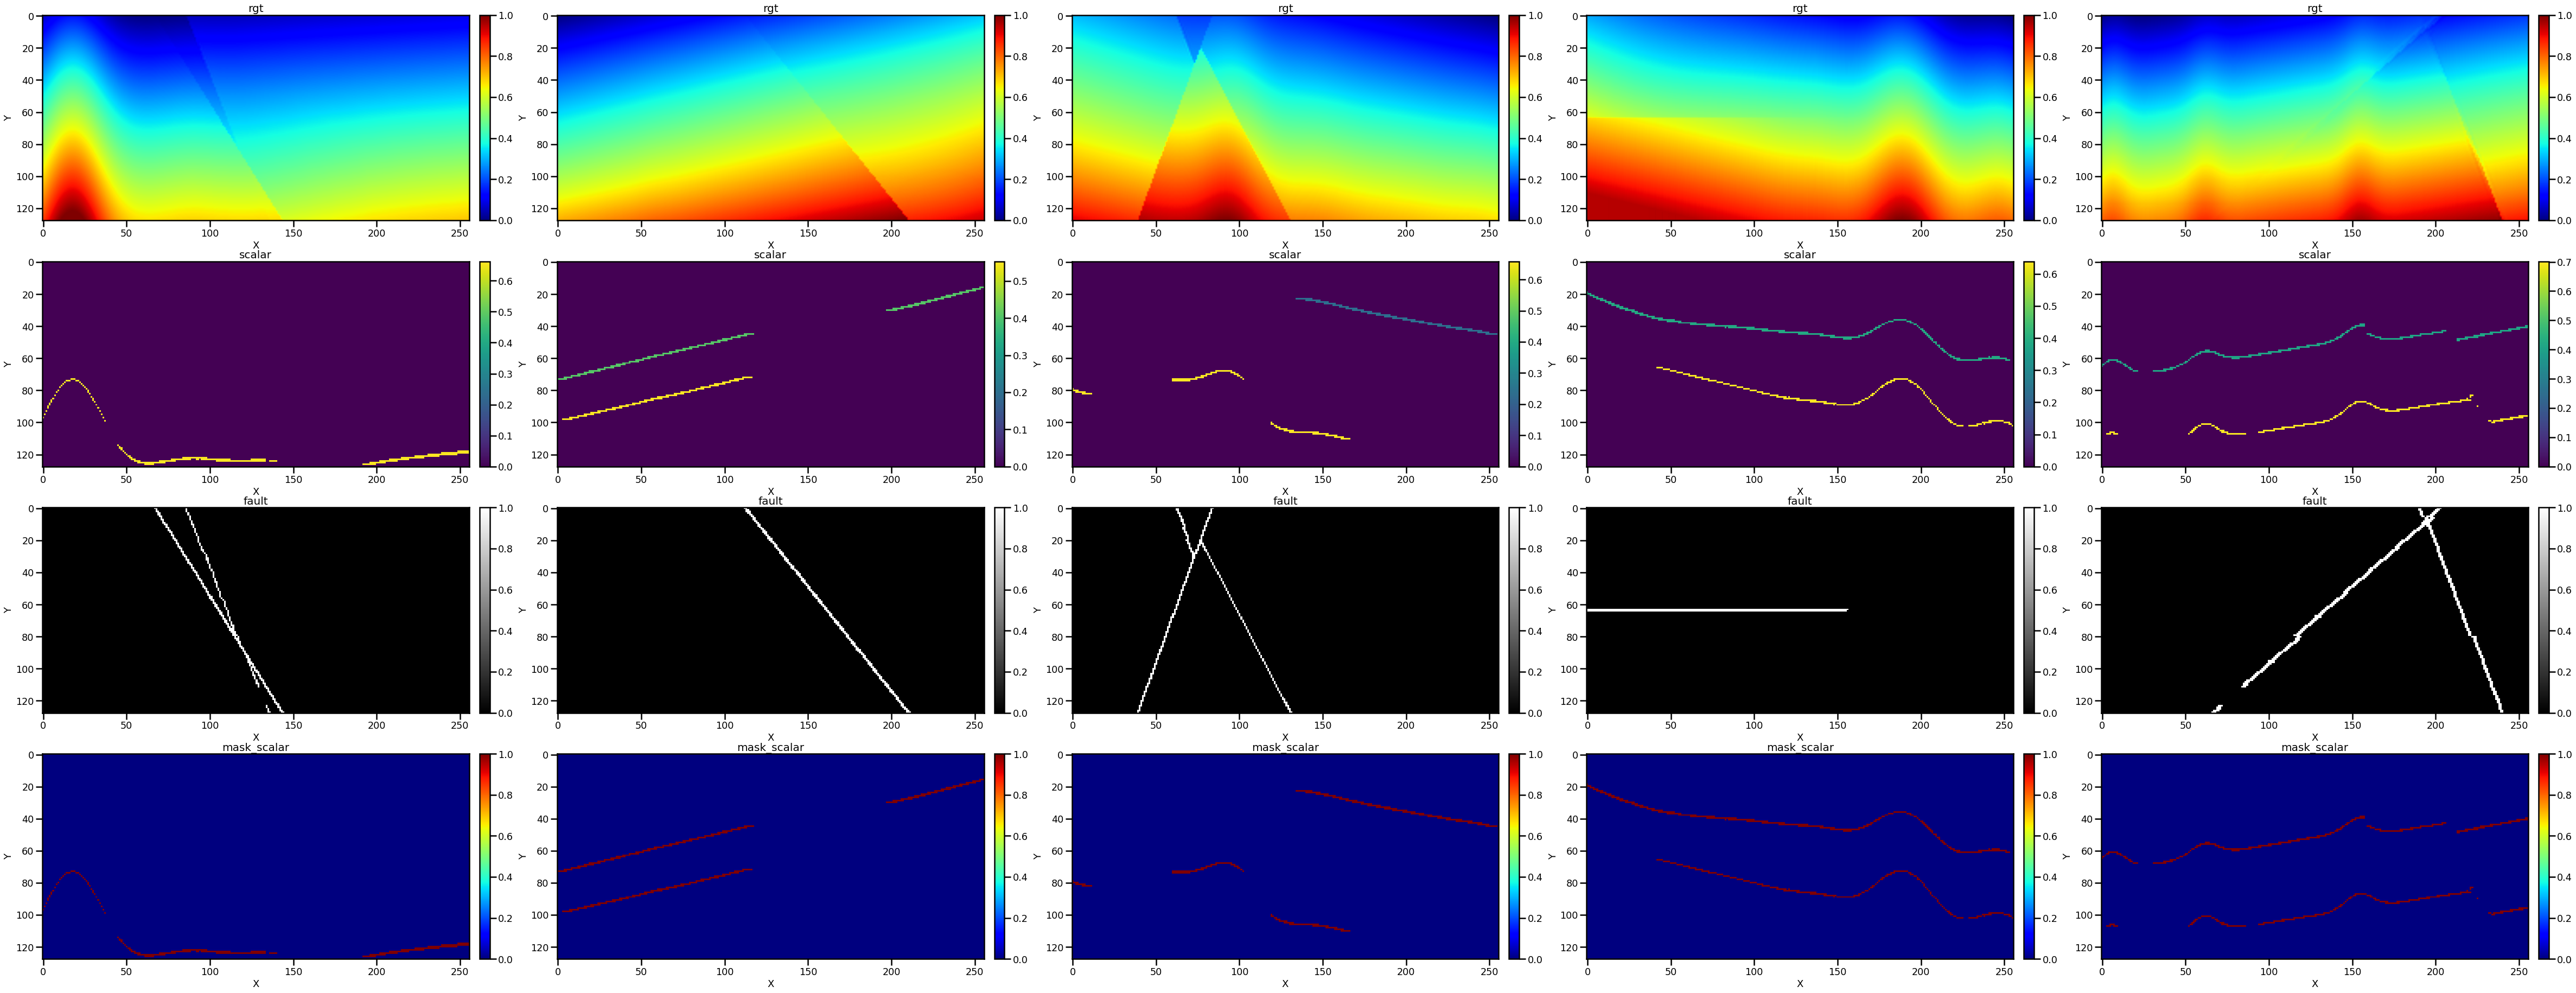

In [4]:
mask = True
batch_samples = [train_data[i] for i in range(100,105)]
draw_attr_list = output_attr_list + input_attr_list
if mask:
    draw_attr_list += ["mask_scalar"]
print(draw_attr_list)
draw.draw_samples(batch_samples, draw_attr_list)

### Training CNN

In [4]:
train_sample_path = os.path.join(dataset_path, "train")
train_data =  utils.build_dataset_rgt(samples_train, train_sample_path, 'Train',
                            possible_num_hrzs, hrz_grp,
                            bit, bit_mute, bit_rate, 
                            fault_range,
                            use_normal=use_normal,
                            norm=norm)

valid_data =  utils.build_dataset_rgt(samples_valid, train_sample_path, 'Valid',
                            possible_num_hrzs, hrz_grp,
                            bit, bit_mute, bit_rate, 
                            fault_range,
                            use_normal=use_normal,
                            norm=norm)

In [5]:
# 定义网络
inshape = (128,256)
param_model = {}
param_model['net_name'] = "UNet"
param_model['input_channels'] = 2 if not use_normal else 4
param_model['output_channels'] = 1
param_model['num_features'] = 1.0 
param_model['expansion'] = 1.5
param_model['inshape'] = inshape

model = getattr(models, param_model['net_name'])(param_model)

# 并行模式
if num_GPU > 1:
    print(f"多核模式")
    model = torch.nn.DataParallel(model, device_ids=range(num_GPU)).to(device)
else:
    print(f"单核模式")
        
model = model.to(device)

单核模式


In [6]:
# 定义训练参数
param = dict(param_model)
param['epochs'] = 121    # 训练轮数
param['batch_size'] = num_GPU * 80 # 批大小
param['inshape'] = inshape 
param['lr'] = 1e-2          # 学习率
param['optimizer_type'] = 'Adam' # 优化器类型
param['weight_decay'] = 0.0 # 权重衰减
param['decay_type'] = 'ReduceLROnPlateau' # 学习率衰减策略
param['gamma'] = 0.5    # 学习率衰减系数
param['lr_decay'] = 2   # 学习率衰减周期
param['disp_inter'] = 2 # 显示间隔
param['save_inter'] = 10 # 保存间隔
param['use_normal'] = use_normal

# param['loss_type'] = {"mae":0.24, "ms-ssim":0.84}
param['loss_type'] = {"ms-ssim":1.0}

loss_name = '+'.join([f"{'{:.2f}'.format(value)}*{key}" for key, value in param['loss_type'].items()])

# 模型保存路径    
session_name = '-'.join([param_model['net_name'], "dataset_"+dataset_name, loss_name])

if use_normal:
    session_name = '-'.join([session_name, "orientation"])                                        
                      
checkpoint_path = os.path.join('checkpoints', session_name)
param['checkpoint_path'] = checkpoint_path
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

print(f"模型读取路径: {checkpoint_path}")

模型读取路径: checkpoints/UNet-dataset_syn_train_valid_rgt-1.00*ms-ssim


In [ ]:
# 训练网络 
model = utils.train_valid_net(param, model, train_data, valid_data, plot=True, device=device)

### Inference

In [62]:
# 设置参数
dataset_name = "syn_train_valid_rgt"
dataset_category = 'samples_valid.npy'
dataset_path = os.path.join(root_path, "datasets", dataset_name)
samples_test = np.load(os.path.join(dataset_path, dataset_category), allow_pickle=True)
samples_test = samples_test[220:230]
print(f"测试样本数量: {len(samples_test)}")
check_data = True

测试样本数量: 10


In [63]:
# 读取数据
test_sample_path = os.path.join(dataset_path, "train")
test_data = utils.build_dataset_rgt(samples_test, test_sample_path, 'Infer',
                            possible_num_hrzs, hrz_grp,
                            bit, bit_mute, bit_rate, 
                            fault_range,
                            use_normal=use_normal,
                            norm=norm)

In [64]:
# 模型读取
# checkpoint_path = "checkpoints/UNet-dataset_syn_train_valid_rgt-1.00*ms-ssim_0620"
checkpoint_file = os.path.join(checkpoint_path, 'checkpoint-best.pth')
# print(f"模型读取路径: {checkpoint_file}")
# if num_GPU == 1:
#     utils.load_model_parameters(model, checkpoint_file, device)
# else:
#     model.load_state_dict(torch.load(checkpoint_file)['state_dict'])
    
# utils.load_model_parameters(model, checkpoint_file, device)
model.load_state_dict(torch.load(checkpoint_file)['state_dict'])

<All keys matched successfully>

In [65]:
pred_samples = utils.pred(model, test_data, use_normal=use_normal, device=device)

['scalar', 'fault', 'rgt', 'pred', 'fitting']


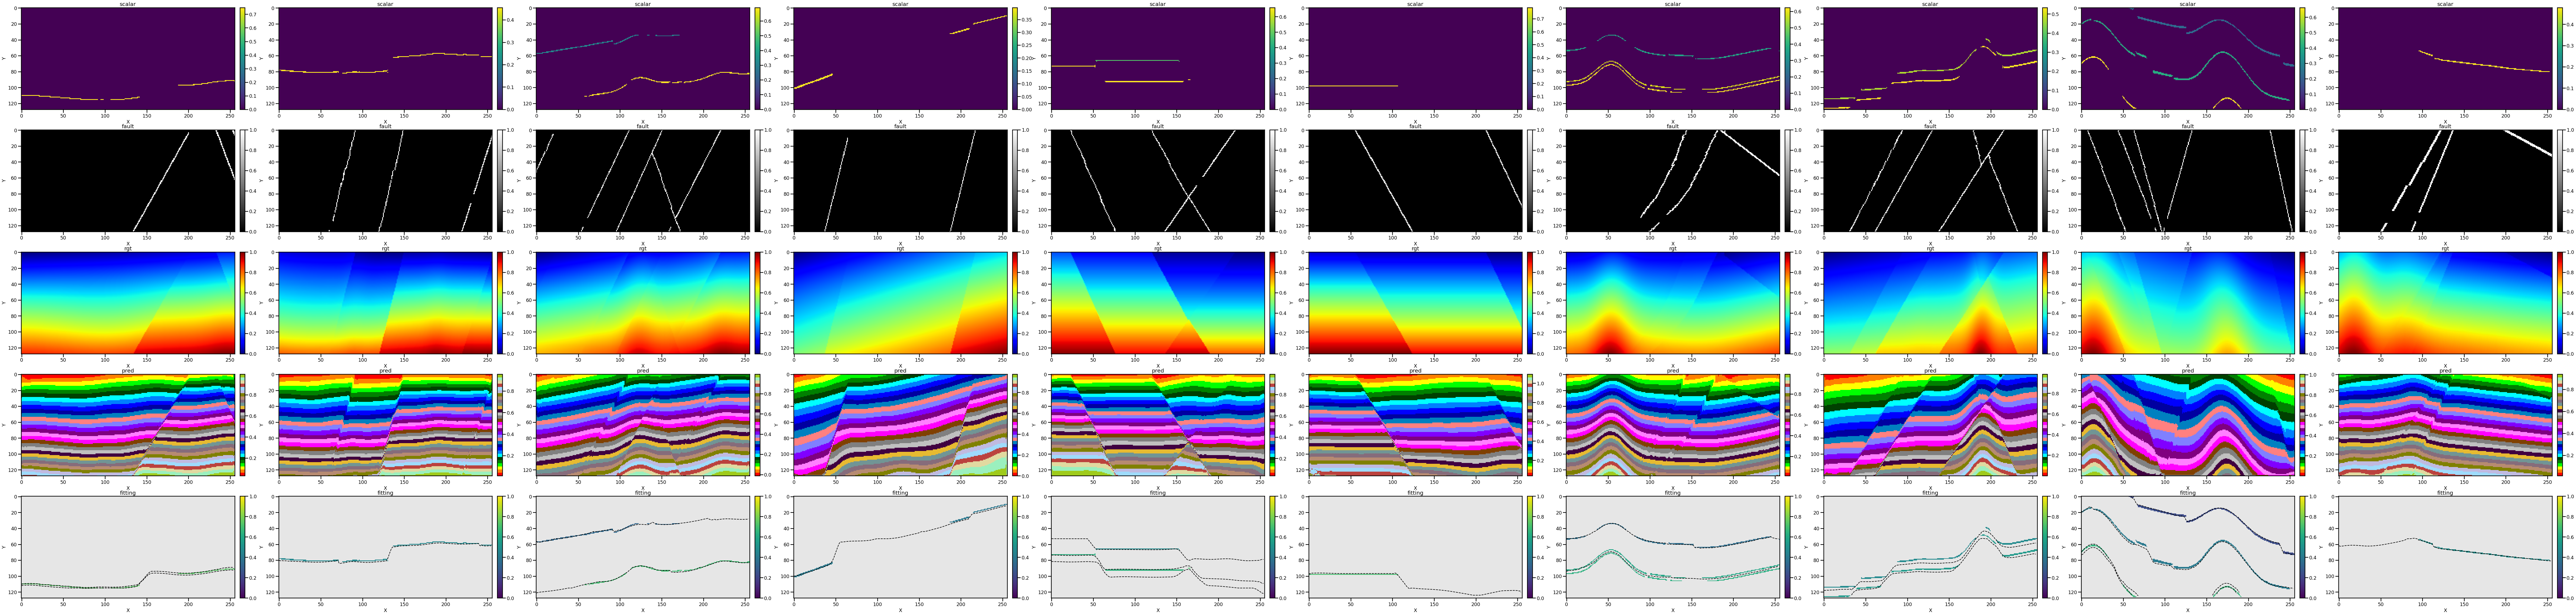

In [66]:
pred_attr_list = ["pred", "fitting"]
print(input_attr_list + output_attr_list + pred_attr_list)
draw.draw_samples(pred_samples, input_attr_list + output_attr_list + pred_attr_list)